In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

Mounted at /content/drive/


In [ ]:
!pip install open3d
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud/cpp_kd_tree')
!python setup.py build_ext --inplace
import PyKDTree
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

In [3]:
import os
import math
import argparse
import torch
import torch.utils.tensorboard
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from utils.dataset import *
from utils.misc import *
from utils.data import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from evaluation import *
from models.vae_trained_z import MyVAE

# src_path = '../pcd_gen_results/pcd_gen1_ckpts/GEN_2022_10_14__08_37_36/ckpt_0.000000_629999.pt'
src_path = '../pcd_gen_results/pcd_gen2_ckpts/GEN_2022_10_14__08_28_48/ckpt_0.000000_629999.pt'
ckpt = torch.load(src_path)

model = MyVAE(ckpt['args']).cuda()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [4]:
ratios = torch.range(0, 1, 0.1).cuda()
ratios.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


torch.Size([11])

torch.Size([2, 524288, 3])
4


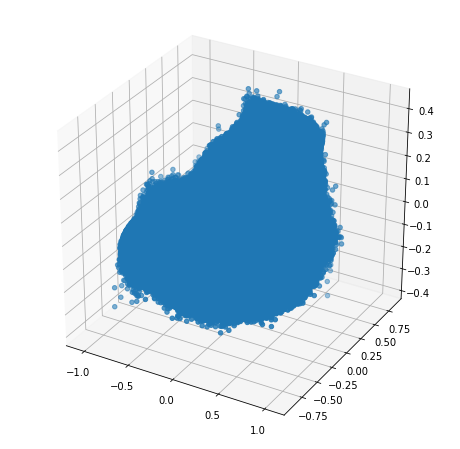

5


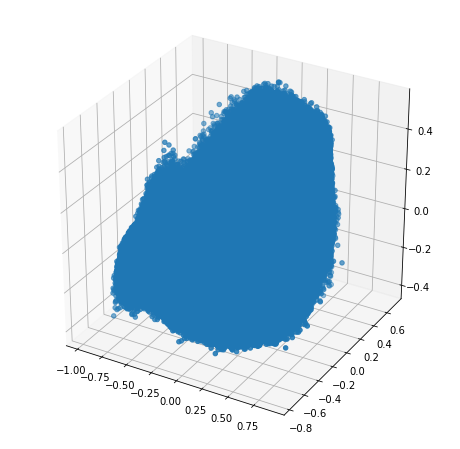

In [5]:
import matplotlib.pyplot as plt
import numpy as np

num = 4
with torch.no_grad():
  interpolate_samples = model.sample_interpolate(num=524288, ratios=ratios[num:num+2])
  print(interpolate_samples.shape)

pts = interpolate_samples.detach().cpu().squeeze()

for i in range(2):
  print(num+i)
  np_pcd = pts[i].numpy()
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
  plt.show()

In [6]:
np_pts = pts.numpy()
pts_0 = np_pts[0]
max_cor = np.max(pts_0, axis=0)
min_cor = np.min(pts_0, axis=0)
eps = 0.2
colors_0 = (pts_0 - min_cor) / (max_cor - min_cor) * (1-eps) + eps

In [7]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts_0)

In [26]:
cl, index = pcd.remove_radius_outlier(nb_points=10, radius=0.08)

In [27]:
np.array(index).shape

(524216,)

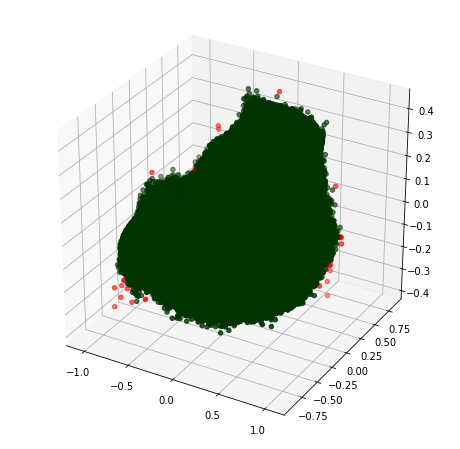

In [28]:
import open3d as o3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
colors = np.zeros_like(pts_0) + np.array([1, 0, 0])
colors[index] = np.array([0, 0.2, 0])

ax.scatter(pts_0[:,0], pts_0[:,1], pts_0[:,2], c=colors)
plt.show()

In [29]:
def kd_index(points):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = np.argsort(tree.output_index())

  return index

def order_pts(points):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = tree.output_index()

  return points[index]

In [30]:
from tqdm import tqdm

pt_clouds = []
indexs = []

for num in tqdm(range(ratios.shape[0])):
  with torch.no_grad():
    interpolate_samples = model.sample_interpolate(num=524288, ratios=ratios[num:num+1])
    print(interpolate_samples.shape)

  pts = order_pts(interpolate_samples.detach().cpu()[0].numpy())
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(pts)
  _, index = pcd.remove_radius_outlier(nb_points=10, radius=0.08)

  pt_clouds.append(torch.tensor(pts).unsqueeze(0))
  indexs.append(torch.tensor(index).unsqueeze(0))

save_dict = {'points':torch.cat(pt_clouds, dim=0), 'index':torch.cat(indexs, dim=0)}
torch.save('./interpolated_hotdog-chair.pth', save_dict)

  # fig = plt.figure(figsize=(8, 8))
  # ax = fig.add_subplot(111, projection='3d')
  # ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
  # plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([1, 524288, 3])


  9%|▉         | 1/11 [01:33<15:31, 93.19s/it]

torch.Size([1, 524288, 3])


 18%|█▊        | 2/11 [03:07<14:02, 93.62s/it]

torch.Size([1, 524288, 3])


 27%|██▋       | 3/11 [04:49<13:02, 97.85s/it]

torch.Size([1, 524288, 3])


 36%|███▋      | 4/11 [06:50<12:26, 106.71s/it]

torch.Size([1, 524288, 3])


 45%|████▌     | 5/11 [09:05<11:42, 117.15s/it]

torch.Size([1, 524288, 3])


 55%|█████▍    | 6/11 [11:26<10:25, 125.02s/it]

torch.Size([1, 524288, 3])


 64%|██████▎   | 7/11 [13:37<08:28, 127.06s/it]

torch.Size([1, 524288, 3])


 73%|███████▎  | 8/11 [15:36<06:13, 124.52s/it]

torch.Size([1, 524288, 3])


 82%|████████▏ | 9/11 [17:30<04:02, 121.08s/it]

torch.Size([1, 524288, 3])


 91%|█████████ | 10/11 [19:24<01:59, 119.10s/it]

torch.Size([1, 524288, 3])


100%|██████████| 11/11 [21:18<00:00, 116.24s/it]


RuntimeError: ignored

In [32]:
save_dict = {'points':torch.cat(pt_clouds, dim=0), 'index':indexs}
torch.save(save_dict, './interpolated_hotdog-chair.pth')

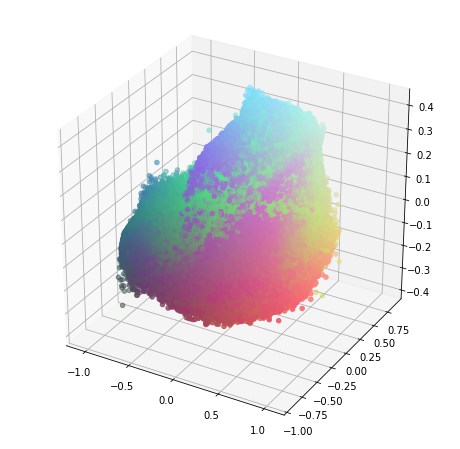

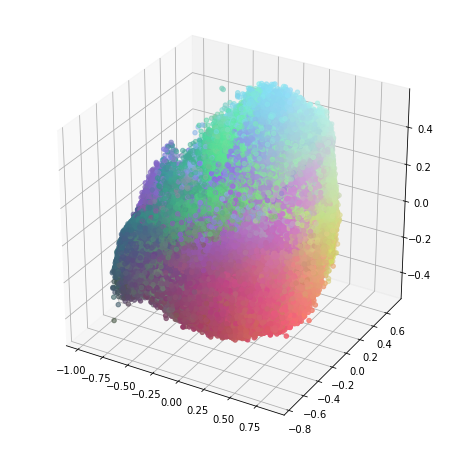

In [28]:
pts_a = order_pts(np_pts[0])
pts_b = order_pts(np_pts[1])
max_cor = np.max(pts_a, axis=0)
min_cor = np.min(pts_a, axis=0)
eps = 0.2
colors = (pts_a - min_cor) / (max_cor - min_cor) * (1-eps) + eps

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_a[index_0,0], pts_a[index_0,1], pts_a[index_0,2], c=colors[index_0])
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_b[index_0,0], pts_b[index_0,1], pts_b[index_0,2], c=colors[index_0])
plt.show()